## Description
This notebook loads datasets with German text and uses BM25 to score how relevant each entry is to a given search query. It then creates to functions with the clusters from DBSCAN and LDA before.

DBSCAN cluster labels are used to compare how close the query is to each cluster. If a good cluster is found, results from that cluster are shown first, then other relevant ones from BM25. If no good cluster is found, only BM25 results are shown.

The second search function combines BM25 with LDA topic distributions to find results that are not only textually similar but also topically related.

The code was developed with support from ChatGPT-4.

In [ ]:
import pandas as pd
from rank_bm25 import BM25Okapi
from gensim.models import LdaModel
from gensim import corpora
import ast
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tabulate import tabulate
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Preprocessing tools
german_stopwords = set(stopwords.words('german'))
stemmer = SnowballStemmer("german")

# Preprocessing function: lowercase, tokenize, remove stopwords and apply stemming
def preprocess(text):
    tokens = word_tokenize(str(text).lower())
    return [stemmer.stem(w) for w in tokens if w.isalnum() and w not in german_stopwords]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\haabs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haabs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
def lda_search(query, df_path="data/02_LDA_cluster.csv", model_path="data/lda_model_50topics.gensim", dict_path="data/lda_dictionary.dict", alpha=0.7, beta=0.3):
    # Load data
    df = pd.read_csv(df_path, low_memory=False)
    df = df[['dataset_title_DE', 'dataset_keyword_DE', 'dataset_description_DE', 'assigned_topic', 'topic_distribution']].fillna('')
    df['dataset_keyword_DE'] = df['dataset_keyword_DE'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Combine text fields and tokenize
    df['combined_text'] = df['dataset_title_DE'] + ' ' + df['dataset_description_DE'] + ' ' + df['dataset_keyword_DE'].astype(str)
    tokenized_docs = df['combined_text'].apply(preprocess).tolist()

    # Initialize BM25
    bm25_docs = BM25Okapi(tokenized_docs)

    # Preprocess query
    query_tokens = preprocess(query)
    doc_scores = bm25_docs.get_scores(query_tokens)

    # Load LDA model and dictionary
    lda_model = LdaModel.load(model_path)
    dictionary = corpora.Dictionary.load(dict_path)
    query_bow = dictionary.doc2bow(query_tokens)
    query_topic_dist = lda_model.get_document_topics(query_bow, minimum_probability=0.05)
    query_topic_dict = dict(query_topic_dist)
    relevant_topics = set(query_topic_dict.keys())

    # Calculate LDA-based topic relevance score
    def compute_lda_score(topic_dist_str):
        try:
            dist = ast.literal_eval(topic_dist_str)
            score = sum(prob for tid, prob in dist if prob > 0.05 and tid in relevant_topics)
            return score * 10  # Scale for better comparison with BM25
        except:
            return 0.0

    # Assign scores
    df['bm25_score'] = doc_scores
    df['lda_score'] = df['topic_distribution'].apply(compute_lda_score)
    df['final_score'] = alpha * df['bm25_score'] + beta * df['lda_score']

    # Filter and sort results
    df = df[df['final_score'] >= 1].sort_values(by='final_score', ascending=False).reset_index(drop=True)

    print(f"\nResults for query: '{query}'")
    print(tabulate(df[['dataset_title_DE', 'bm25_score', 'lda_score', 'final_score']], headers='keys', tablefmt='fancy_grid', showindex=True))

    return df

In [37]:
def dbscan_search(query, df_path="data/01_DBSCAN_cluster.csv", alpha=0.7, beta=0.3):
    # Load data
    df = pd.read_csv(df_path, low_memory=False)
    df = df[['dataset_title_DE', 'dataset_keyword_DE', 'dataset_description_DE', 'cluster']].fillna('')
    df['combined_text'] = df['dataset_title_DE'] + ' ' + df['dataset_description_DE'] + ' ' + df['dataset_keyword_DE'].astype(str)

    # Tokenize documents and initialize BM25
    tokenized_docs = df['combined_text'].apply(preprocess).tolist()
    bm25_docs = BM25Okapi(tokenized_docs)

    # Preprocess query
    query_tokens = preprocess(query)
    doc_scores = bm25_docs.get_scores(query_tokens)

    # Filter out invalid clusters for scoring
    valid_cluster_df = df[~df['cluster'].isin([-1, -2])]

    # Build cluster representations from valid clusters
    cluster_representations = {}
    for cluster_id in valid_cluster_df['cluster'].unique():
        cluster_texts = valid_cluster_df[valid_cluster_df['cluster'] == cluster_id]['combined_text']
        tokens = [token for doc in cluster_texts for token in preprocess(doc)]
        cluster_representations[cluster_id] = tokens

    # BM25 at cluster level
    if cluster_representations:
        bm25_clusters = BM25Okapi(list(cluster_representations.values()))
        cluster_scores = bm25_clusters.get_scores(query_tokens)
        cluster_score_map = dict(zip(cluster_representations.keys(), cluster_scores))
    else:
        cluster_score_map = {}

    # Compute final document scores (for all documents, including cluster -1 and -2)
    df['bm25_score'] = doc_scores
    df['cluster_score'] = df['cluster'].apply(lambda cid: cluster_score_map.get(cid, 0))
    df['combined_score'] = alpha * df['bm25_score'] + beta * df['cluster_score']

    # Identify best matching cluster
    if cluster_score_map:
        best_cluster_id, best_cluster_score = max(cluster_score_map.items(), key=lambda x: x[1])
    else:
        best_cluster_id, best_cluster_score = None, 0

    # Select documents
    df_result = pd.DataFrame()

    if best_cluster_id is not None and best_cluster_score >= 1:
        df_cluster = df[df['cluster'] == best_cluster_id]
        df_bm25_only = df[(df['bm25_score'] > 0) & (df['cluster'] != best_cluster_id)]
        df_result = pd.concat([df_cluster, df_bm25_only])
        print(f"\nQuery: '{query}'")
        print(f"Best matching cluster: {best_cluster_id} with cluster_score: {best_cluster_score:.2f}")
    else:
        df_result = df[df['bm25_score'] > 0]
        print(f"\nNo suitable cluster found (score < 1) – showing only BM25-relevant results.")

    # Sort and filter final result
    df_result = df_result[df_result['combined_score'] > 0]
    df_result = df_result.sort_values(by='combined_score', ascending=False).reset_index(drop=True)

    # Display results
    print(tabulate(df_result[['dataset_title_DE', 'bm25_score', 'cluster_score', 'combined_score']],
                   headers='keys', tablefmt='fancy_grid', showindex=True))

    return df_result

In [ ]:
# Define the search query
query = "Veloweg"

# Execute both search functions
df_dbscan = dbscan_search(query)
df_lda = semantische_suche(query)


Query: 'Veloweg'
Best matching cluster: 2.0 with cluster_score: 5.46
╒════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════╤═════════════════╤══════════════════╕
│    │ dataset_title_DE                                                                                                                                                                                 │   bm25_score │   cluster_score │   combined_score │
╞════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════╪═════════════════╪══════════════════╡
│  0 │ Bundesbeschluss über die Velowege sowie die Fuss- und Wanderwege                                                                                                 

Number of DBSCAN results: 37
Number of LDA results: 92
Number of common results (title + description): 7


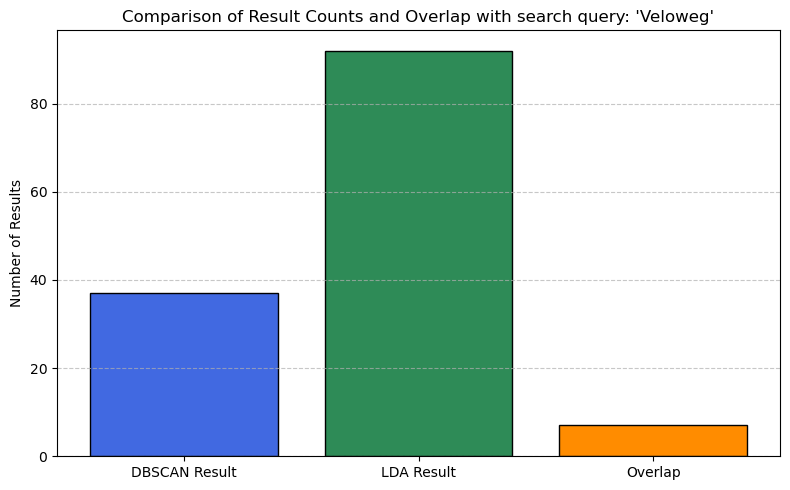

In [51]:
# Comparison key: combination of title and description
dbscan_keys = set((row['dataset_title_DE'], row['dataset_description_DE']) for _, row in df_dbscan.iterrows())
lda_keys = set((row['dataset_title_DE'], row['dataset_description_DE']) for _, row in df_lda.iterrows())

# Determine the overlap
common_keys = dbscan_keys & lda_keys

# Count the results
count_dbscan = len(dbscan_keys)
count_lda = len(lda_keys)
count_common = len(common_keys)

# Print result counts
print(f"Number of DBSCAN results: {count_dbscan}")
print(f"Number of LDA results: {count_lda}")
print(f"Number of common results (title + description): {count_common}")

# Visualization
plt.figure(figsize=(8, 5))
labels = ['DBSCAN Result', 'LDA Result', 'Overlap']
counts = [count_dbscan, count_lda, count_common]
plt.bar(labels, counts, color=['royalblue', 'seagreen', 'darkorange'], edgecolor='black')
plt.title(f"Comparison of Result Counts and Overlap with search query: \'{query}\'")
plt.ylabel("Number of Results")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Stimmt noch nicht!